### Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from datetime import timedelta
import csv
from tqdm import tqdm
from keras.backend import clear_session
import gc

from autoencoder import create_train_val_set_random, create_autoencoder,fit_autoencoder_custom, hyperparameter_tuning, optimize_latent_variables
from Jcb import calc_basis_matrix, Jcb
from plot_fun import subplot_results

### Problem parameters

In [3]:
run = 4
sub_x = 2
sub_y = 2
epochs = 1_000
num_designs = 1_000
patience_prc = 0.3
batch_size = 256
levels = np.linspace(-1,1,3).tolist()
optimality = 'A'
nx = [3]
n_b = [3]
scalars = 0
optimizer_parameters = {'learning_rate': 0.01}

### Set up

In [4]:
J_cb = Jcb(*[calc_basis_matrix(x_basis=x, b_basis=b) for x, b in zip(nx, n_b)])
des_pure_train, des_pure_val,des_noisy_train, des_noisy_val = create_train_val_set_random(runs=run,
                                                                                          n_x=nx,
                                                                                          scalars=scalars,
                                                                                          optimality=optimality,
                                                                                          J_cb=J_cb,
                                                                                          noise=0.9,
                                                                                          num_designs=num_designs,
                                                                                          epsilon=1e-10)

  1%|          | 1007/100000 [00:00<00:01, 71161.76it/s]


### Hyperparameter tuning

In [28]:
best_latent_dim, best_alpha = hyperparameter_tuning(des_pure_train=des_pure_train,
                                                    des_pure_val=des_pure_val,
                                                    nn_epochs=100,
                                                    n_calls=10,
                                                    run=run,
                                                    nx=nx,
                                                    J_cb=J_cb,
                                                    batch_size=batch_size,
                                                    optimizer_parameters=optimizer_parameters)
print(f'Best latent dimension: {best_latent_dim} \nBest alpha: {best_alpha}')

Iteration No: 1 started. Evaluating function at random point.
Epoch 1/100
4/4 [==============================] - 0s 27ms/step - loss: 115024.9297 - val_loss: 97429.3594
Epoch 2/100
4/4 [==============================] - 0s 5ms/step - loss: 84703.9531 - val_loss: 81266.0078
Epoch 3/100
4/4 [==============================] - 0s 5ms/step - loss: 78610.8281 - val_loss: 77009.9141
Epoch 4/100
4/4 [==============================] - 0s 5ms/step - loss: 76797.6719 - val_loss: 78784.5000
Epoch 5/100
4/4 [==============================] - 0s 6ms/step - loss: 63425.5117 - val_loss: 81202.7422
Epoch 6/100
4/4 [==============================] - 0s 5ms/step - loss: 61693.9688 - val_loss: 51929.3555
Epoch 7/100
4/4 [==============================] - 0s 5ms/step - loss: 43656.1602 - val_loss: 63052.9766
Epoch 8/100
4/4 [==============================] - 0s 5ms/step - loss: 48009.7109 - val_loss: 58434.2891
Epoch 9/100
4/4 [==============================] - 0s 5ms/step - loss: 49324.6719 - val_loss: 76

### Create and Train NN

In [6]:
# 22, 0.0001
autoencoder, encoder, decoder = create_autoencoder(input_dim=des_pure_train.shape[1],
                                                   latent_dim=best_latent_dim,
                                                   alpha=best_alpha)
autoencoder, encoder, decoder, history = fit_autoencoder_custom(autoencoder=autoencoder,
                                                                encoder=encoder,
                                                                decoder=decoder,
                                                                train_data=des_pure_train,
                                                                val_data=des_pure_val,
                                                                epochs=epochs,
                                                                batch_size=batch_size,
                                                                patience=patience_prc*epochs,
                                                                m=run,
                                                                n=sum(nx),
                                                                J_cb=J_cb)

Epoch 1/1000
4/4 [==============================] - 0s 32ms/step - loss: 1163237.2500 - val_loss: 679461.2500
Epoch 2/1000
4/4 [==============================] - 0s 5ms/step - loss: 611564.8125 - val_loss: 462050.7188
Epoch 3/1000
4/4 [==============================] - 0s 6ms/step - loss: 420879.8438 - val_loss: 335438.5312
Epoch 4/1000
4/4 [==============================] - 0s 7ms/step - loss: 312556.6250 - val_loss: 260626.7656
Epoch 5/1000
4/4 [==============================] - 0s 7ms/step - loss: 246076.9219 - val_loss: 211725.7656
Epoch 6/1000
4/4 [==============================] - 0s 7ms/step - loss: 201137.4844 - val_loss: 176674.4375
Epoch 7/1000
4/4 [==============================] - 0s 6ms/step - loss: 168549.8125 - val_loss: 148910.1250
Epoch 8/1000
4/4 [==============================] - 0s 7ms/step - loss: 142809.9219 - val_loss: 128209.7031
Epoch 9/1000
4/4 [==============================] - 0s 5ms/step - loss: 123316.1328 - val_loss: 111327.8516
Epoch 10/1000
4/4 [=======

### Optimize latent space

In [7]:
optimal_latent_var, optimal_cr, optimal_des = optimize_latent_variables(best_latent_dim=best_latent_dim,
                                                                        decoder=decoder,
                                                                        run=run,
                                                                        nx=nx,
                                                                        J_cb=J_cb,
                                                                        n_calls=50)

Iteration No: 1 started. Evaluating function at random point.
1/1 [==============================] - 0s 52ms/step
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.4198
Function value obtained: 393.4420
Current minimum: 393.4420
Iteration No: 2 started. Evaluating function at random point.
1/1 [==============================] - 0s 9ms/step
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0258
Function value obtained: 387.4361
Current minimum: 387.4361
Iteration No: 3 started. Evaluating function at random point.
1/1 [==============================] - 0s 8ms/step
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0192
Function value obtained: 458.4700
Current minimum: 387.4361
Iteration No: 4 started. Evaluating function at random point.
1/1 [==============================] - 0s 9ms/step
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0246
Function value obtained: 663.6877
Current minimum: 387.4361
Iterati

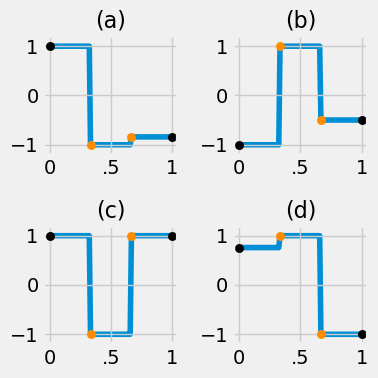

In [8]:
figure = subplot_results(sub_x=sub_x, sub_y=sub_y, T=np.linspace(0, 1, 100), results=np.round(optimal_des, 3), show=False)

### Loop

In [3]:
# Initialize a CSV file for storing the results
csv_filename = "results_simpleNN.csv"
csv_header = ["Run", "nx", "Optimal CR", "Execution Time (s)", "Latent Dim", "Alpha"]

with open(csv_filename, mode='w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(csv_header)

In [4]:
              # 3      # 4      # 8      # 16      # 100
best_hyper = [[2,0,10],[2,0,10],[2,0,10],[7,0,10], [10,0,10],  # 4
              [2,0,10],[5,0,10],[2,0,10],[4,0,10], [15,0,10],  # 8
              [3,0,10],[1,0,10],[3,0,10],[10,0,10],[10,0,10]]  # 12

runs = [4, 8, 12]
nx_s = [[3], [4], [8], [16], [100]]
n_b = [3]

In [7]:
total_iterations = len(runs) * len(nx_s)
pbar = tqdm(total=total_iterations, desc="Overall Progress")
for run in runs:
    for i, nx in enumerate(nx_s):

        # Extract the best hyperparameters based on the current run and nx combination
        # index = runs.index(run) * len(nx) + i
        # hyper = best_hyper[index]

        J_cb = Jcb(*[calc_basis_matrix(x_basis=x, b_basis=b) for x, b in zip(nx, n_b)])
        des_pure_train, des_pure_val,_, _ = create_train_val_set_random(runs=run,
                                                                        n_x=nx,
                                                                        scalars=scalars,
                                                                        optimality=optimality,
                                                                        J_cb=J_cb,
                                                                        noise=0.9,
                                                                        num_designs=num_designs,
                                                                        epsilon=1e-10)
        best_latent_dim, best_alpha = hyperparameter_tuning(des_pure_train=des_pure_train,
                                                            des_pure_val=des_pure_val,
                                                            nn_epochs=100,
                                                            n_calls=10,
                                                            run=run,
                                                            nx=nx,
                                                            J_cb=J_cb,
                                                            batch_size=batch_size,
                                                            optimizer_parameters=optimizer_parameters)

        start = timer()

        autoencoder, encoder, decoder = create_autoencoder(input_dim=des_pure_train.shape[1],
                                                           latent_dim=best_latent_dim,
                                                           alpha=best_alpha)
        autoencoder, encoder, decoder, _ = fit_autoencoder_custom(autoencoder=autoencoder,
                                                                  encoder=encoder,
                                                                  decoder=decoder,
                                                                  train_data=des_pure_train,
                                                                  val_data=des_pure_val,
                                                                  epochs=epochs,
                                                                  batch_size=batch_size,
                                                                  patience=patience_prc*epochs,
                                                                  m=run,
                                                                  n=sum(nx),
                                                                  J_cb=J_cb)
        _, optimal_cr, _ = optimize_latent_variables(best_latent_dim=best_latent_dim,
                                                     decoder=decoder,
                                                     run=run,
                                                     nx=nx,
                                                     J_cb=J_cb,
                                                     n_calls=10)

        end = timer()
        del autoencoder
        del encoder
        del decoder
        clear_session()
        gc.collect()
        exec_time = timedelta(seconds=end - start).total_seconds()

        # Store the results in the CSV file
        with open(csv_filename, mode='a', newline='') as csv_file:
            csv_writer = csv.writer(csv_file)
            csv_writer.writerow([run, sum(nx), np.round(optimal_cr,3), exec_time, best_latent_dim, best_alpha])
        pbar.update(1)
pbar.close()
print("DONE")


  1%|          | 1011/100000 [00:00<00:02, 41821.42it/s]
2023-10-24 16:55:39.638796: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Iteration No: 1 started. Evaluating function at random point.
Epoch 1/100
4/4 [==============================] - 1s 37ms/step - loss: 101346.6406 - val_loss: 92902.7969
Epoch 2/100
4/4 [==============================] - 0s 5ms/step - loss: 90044.7031 - val_loss: 76777.1094
Epoch 3/100
4/4 [==============================] - 0s 5ms/step - loss: 82732.3750 - val_loss: 76746.2812
Epoch 4/100
4/4 [==============================] - 0s 4ms/step - loss: 79479.7891 - val_loss: 93692.2031
Epoch 5/100
4/4 [==============================] - 0s 5ms/step - loss: 78735.1875 - val_loss: 75188.4375
Epoch 6/100
4/4 [==============================] - 0s 4ms/step - loss: 71717.7031 - val_loss: 82737.7266
Epoch 7/100
4/4 [==============================] - 0s 6ms/step - loss: 58874.7539 - val_loss: 76693.6406
Epoch 8/100
4/4 [==============================] - 0s 5ms/step - loss: 50100.9609 - val_loss: 45737.0391
Epoch 9/100
4/4 [==============================] - 0s 5ms/step - loss: 63223.7852 - val_loss: 60


  1%|          | 1009/100000 [00:00<00:01, 60074.28it/s].50s/it]

Iteration No: 1 started. Evaluating function at random point.
Epoch 1/100


4/4 [==============================] - 0s 27ms/step - loss: 110664.8828 - val_loss: 73885.2812
Epoch 2/100
4/4 [==============================] - 0s 4ms/step - loss: 85067.9609 - val_loss: 87234.0234
Epoch 3/100
4/4 [==============================] - 0s 6ms/step - loss: 75693.8906 - val_loss: 79730.0000
Epoch 4/100
4/4 [==============================] - 0s 4ms/step - loss: 67633.0234 - val_loss: 85520.3516
Epoch 5/100
4/4 [==============================] - 0s 5ms/step - loss: 52305.8242 - val_loss: 55225.4961
Epoch 6/100
4/4 [==============================] - 0s 5ms/step - loss: 46370.6406 - val_loss: 65103.7891
Epoch 7/100
4/4 [==============================] - 0s 5ms/step - loss: 54750.0312 - val_loss: 61195.4297
Epoch 8/100
4/4 [==============================] - 0s 4ms/step - loss: 48899.1367 - val_loss: 64605.3086
Epoch 9/100
4/4 [==============================] - 0s 5ms/step - loss: 40798.1641 - val_loss: 57041.9883
Epoch 10/100
4/4 [==============================] - 0s 4ms/step -


  1%|          | 1025/100000 [00:00<00:01, 87271.36it/s].46s/it]

Iteration No: 1 started. Evaluating function at random point.
Epoch 1/100


4/4 [==============================] - 0s 26ms/step - loss: 126444.6328 - val_loss: 58795.8281
Epoch 2/100
4/4 [==============================] - 0s 4ms/step - loss: 43796.4531 - val_loss: 53308.8398
Epoch 3/100
4/4 [==============================] - 0s 5ms/step - loss: 32044.4375 - val_loss: 19941.8848
Epoch 4/100
4/4 [==============================] - 0s 5ms/step - loss: 14803.5137 - val_loss: 19198.8359
Epoch 5/100
4/4 [==============================] - 0s 5ms/step - loss: 22426.8691 - val_loss: 18166.5391
Epoch 6/100
4/4 [==============================] - 0s 5ms/step - loss: 14252.2949 - val_loss: 10929.6572
Epoch 7/100
4/4 [==============================] - 0s 5ms/step - loss: 16307.6592 - val_loss: 17863.8145
Epoch 8/100
4/4 [==============================] - 0s 4ms/step - loss: 8602.0615 - val_loss: 5876.7588
Epoch 9/100
4/4 [==============================] - 0s 5ms/step - loss: 8418.4180 - val_loss: 7815.7539
Epoch 10/100
4/4 [==============================] - 0s 4ms/step - los


  1%|          | 1051/100000 [00:00<00:01, 89798.60it/s].54s/it]

Iteration No: 1 started. Evaluating function at random point.
Epoch 1/100


4/4 [==============================] - 0s 27ms/step - loss: 265091.8750 - val_loss: 4411.7070
Epoch 2/100
4/4 [==============================] - 0s 4ms/step - loss: 4318.9541 - val_loss: 3236.8323
Epoch 3/100
4/4 [==============================] - 0s 4ms/step - loss: 3174.8591 - val_loss: 2626.0532
Epoch 4/100
4/4 [==============================] - 0s 4ms/step - loss: 2568.6572 - val_loss: 2198.1682
Epoch 5/100
4/4 [==============================] - 0s 4ms/step - loss: 2140.8955 - val_loss: 1887.5110
Epoch 6/100
4/4 [==============================] - 0s 4ms/step - loss: 1833.3101 - val_loss: 1632.3707
Epoch 7/100
4/4 [==============================] - 0s 4ms/step - loss: 1579.8644 - val_loss: 1420.9968
Epoch 8/100
4/4 [==============================] - 0s 4ms/step - loss: 1371.8221 - val_loss: 1240.7532
Epoch 9/100
4/4 [==============================] - 0s 4ms/step - loss: 1193.7335 - val_loss: 1083.6921
Epoch 10/100
4/4 [==============================] - 0s 4ms/step - loss: 1041.0693 


  2%|▏         | 2245/100000 [00:00<00:01, 95518.49it/s].33s/it]

Iteration No: 1 started. Evaluating function at random point.
Epoch 1/100


4/4 [==============================] - 1s 37ms/step - loss: 854212.8750 - val_loss: 548.7496
Epoch 2/100
4/4 [==============================] - 0s 8ms/step - loss: 539.3482 - val_loss: 517.1208
Epoch 3/100
4/4 [==============================] - 0s 8ms/step - loss: 510.2888 - val_loss: 493.2828
Epoch 4/100
4/4 [==============================] - 0s 8ms/step - loss: 487.7336 - val_loss: 473.6870
Epoch 5/100
4/4 [==============================] - 0s 8ms/step - loss: 469.0249 - val_loss: 457.1883
Epoch 6/100
4/4 [==============================] - 0s 8ms/step - loss: 453.2584 - val_loss: 443.2747
Epoch 7/100
4/4 [==============================] - 0s 8ms/step - loss: 440.0002 - val_loss: 431.8660
Epoch 8/100
4/4 [==============================] - 0s 8ms/step - loss: 429.2655 - val_loss: 422.8024
Epoch 9/100
4/4 [==============================] - 0s 8ms/step - loss: 420.7320 - val_loss: 415.5658
Epoch 10/100
4/4 [==============================] - 0s 8ms/step - loss: 413.8798 - val_loss: 409.58


  1%|          | 1000/100000 [00:00<00:00, 100732.60it/s]15s/it]

Iteration No: 1 started. Evaluating function at random point.
Epoch 1/100


4/4 [==============================] - 0s 25ms/step - loss: 8248.2656 - val_loss: 2000.8746
Epoch 2/100
4/4 [==============================] - 0s 4ms/step - loss: 1835.5430 - val_loss: 1325.4258
Epoch 3/100
4/4 [==============================] - 0s 4ms/step - loss: 1238.5852 - val_loss: 974.8275
Epoch 4/100
4/4 [==============================] - 0s 4ms/step - loss: 917.7803 - val_loss: 749.7608
Epoch 5/100
4/4 [==============================] - 0s 4ms/step - loss: 711.3232 - val_loss: 594.8121
Epoch 6/100
4/4 [==============================] - 0s 4ms/step - loss: 567.1785 - val_loss: 487.6806
Epoch 7/100
4/4 [==============================] - 0s 4ms/step - loss: 467.4906 - val_loss: 410.0350
Epoch 8/100
4/4 [==============================] - 0s 4ms/step - loss: 395.0348 - val_loss: 349.1174
Epoch 9/100
4/4 [==============================] - 0s 4ms/step - loss: 339.3487 - val_loss: 306.8449
Epoch 10/100
4/4 [==============================] - 0s 4ms/step - loss: 299.9803 - val_loss: 275.


  1%|          | 1000/100000 [00:00<00:01, 84538.72it/s].65s/it]

Iteration No: 1 started. Evaluating function at random point.
Epoch 1/100


4/4 [==============================] - 0s 25ms/step - loss: 13179.4971 - val_loss: 2353.8362
Epoch 2/100
4/4 [==============================] - 0s 4ms/step - loss: 2093.6174 - val_loss: 1495.2144
Epoch 3/100
4/4 [==============================] - 0s 4ms/step - loss: 1379.8445 - val_loss: 1047.0140
Epoch 4/100
4/4 [==============================] - 0s 4ms/step - loss: 986.8911 - val_loss: 786.9344
Epoch 5/100
4/4 [==============================] - 0s 4ms/step - loss: 752.4158 - val_loss: 618.0527
Epoch 6/100
4/4 [==============================] - 0s 4ms/step - loss: 596.3251 - val_loss: 498.9065
Epoch 7/100
4/4 [==============================] - 0s 4ms/step - loss: 483.8788 - val_loss: 416.6487
Epoch 8/100
4/4 [==============================] - 0s 4ms/step - loss: 404.7797 - val_loss: 351.2166
Epoch 9/100
4/4 [==============================] - 0s 4ms/step - loss: 341.9695 - val_loss: 303.5729
Epoch 10/100
4/4 [==============================] - 0s 4ms/step - loss: 295.9051 - val_loss: 26


  1%|          | 1000/100000 [00:00<00:01, 98980.63it/s].48s/it]

Iteration No: 1 started. Evaluating function at random point.
Epoch 1/100


4/4 [==============================] - 0s 27ms/step - loss: 58117.7344 - val_loss: 1515.2866
Epoch 2/100
4/4 [==============================] - 0s 5ms/step - loss: 1367.9730 - val_loss: 1280.3053
Epoch 3/100
4/4 [==============================] - 0s 4ms/step - loss: 1165.6932 - val_loss: 1090.4578
Epoch 4/100
4/4 [==============================] - 0s 5ms/step - loss: 998.5106 - val_loss: 933.3840
Epoch 5/100
4/4 [==============================] - 0s 4ms/step - loss: 856.2942 - val_loss: 789.4348
Epoch 6/100
4/4 [==============================] - 0s 4ms/step - loss: 725.4543 - val_loss: 663.7800
Epoch 7/100
4/4 [==============================] - 0s 4ms/step - loss: 611.4180 - val_loss: 556.1343
Epoch 8/100
4/4 [==============================] - 0s 4ms/step - loss: 513.7070 - val_loss: 465.0042
Epoch 9/100
4/4 [==============================] - 0s 4ms/step - loss: 431.2176 - val_loss: 391.2129
Epoch 10/100
4/4 [==============================] - 0s 4ms/step - loss: 364.8407 - val_loss: 33


  1%|          | 1000/100000 [00:00<00:01, 83347.65it/s].65s/it]

Iteration No: 1 started. Evaluating function at random point.
Epoch 1/100


4/4 [==============================] - 0s 29ms/step - loss: 229349.6875 - val_loss: 594.0031
Epoch 2/100
4/4 [==============================] - 0s 5ms/step - loss: 571.3597 - val_loss: 503.4455
Epoch 3/100
4/4 [==============================] - 0s 5ms/step - loss: 489.5094 - val_loss: 441.7841
Epoch 4/100
4/4 [==============================] - 0s 5ms/step - loss: 431.7553 - val_loss: 394.9525
Epoch 5/100
4/4 [==============================] - 0s 5ms/step - loss: 386.8380 - val_loss: 357.1190
Epoch 6/100
4/4 [==============================] - 0s 5ms/step - loss: 350.1809 - val_loss: 324.5100
Epoch 7/100
4/4 [==============================] - 0s 5ms/step - loss: 318.4373 - val_loss: 296.7362
Epoch 8/100
4/4 [==============================] - 0s 5ms/step - loss: 291.2922 - val_loss: 272.7789
Epoch 9/100
4/4 [==============================] - 0s 5ms/step - loss: 267.8279 - val_loss: 251.9214
Epoch 10/100
4/4 [==============================] - 0s 5ms/step - loss: 247.4183 - val_loss: 233.41


  1%|          | 1000/100000 [00:00<00:01, 76045.76it/s].59s/it]

Iteration No: 1 started. Evaluating function at random point.
Epoch 1/100


4/4 [==============================] - 1s 42ms/step - loss: 745060.9375 - val_loss: 4475.7573
Epoch 2/100
4/4 [==============================] - 0s 13ms/step - loss: 4081.7727 - val_loss: 3365.0371
Epoch 3/100
4/4 [==============================] - 0s 13ms/step - loss: 3041.4797 - val_loss: 2249.5405
Epoch 4/100
4/4 [==============================] - 0s 12ms/step - loss: 2249.0405 - val_loss: 2236.4629
Epoch 5/100
4/4 [==============================] - 0s 12ms/step - loss: 2107.7629 - val_loss: 2007.8735
Epoch 6/100
4/4 [==============================] - 0s 13ms/step - loss: 1974.8392 - val_loss: 1949.8014
Epoch 7/100
4/4 [==============================] - 0s 12ms/step - loss: 1946.6946 - val_loss: 1742.9771
Epoch 8/100
4/4 [==============================] - 0s 13ms/step - loss: 1712.6082 - val_loss: 1566.5586
Epoch 9/100
4/4 [==============================] - 0s 12ms/step - loss: 1508.1285 - val_loss: 1366.9597
Epoch 10/100
4/4 [==============================] - 0s 12ms/step - loss: 1

/Users/thodorisladas/miniforge3/envs/optidex/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


4/4 [==============================] - 1s 43ms/step - loss: 778637.0625 - val_loss: 250.4997
Epoch 2/100
4/4 [==============================] - 0s 13ms/step - loss: 184.5030 - val_loss: 124.9288
Epoch 3/100
4/4 [==============================] - 0s 12ms/step - loss: 120.0158 - val_loss: 111.3100
Epoch 4/100
4/4 [==============================] - 0s 12ms/step - loss: 109.7052 - val_loss: 107.1449
Epoch 5/100
4/4 [==============================] - 0s 13ms/step - loss: 106.3151 - val_loss: 104.5279
Epoch 6/100
4/4 [==============================] - 0s 12ms/step - loss: 103.9988 - val_loss: 102.1368
Epoch 7/100
4/4 [==============================] - 0s 12ms/step - loss: 101.2227 - val_loss: 100.0891
Epoch 8/100
4/4 [==============================] - 0s 12ms/step - loss: 99.9098 - val_loss: 99.6171
Epoch 9/100
4/4 [==============================] - 0s 13ms/step - loss: 99.5685 - val_loss: 99.2845
Epoch 10/100
4/4 [==============================] - 0s 12ms/step - loss: 99.2347 - val_loss: 99


  1%|          | 1000/100000 [00:00<00:01, 80743.54it/s]1.32s/it]

Iteration No: 1 started. Evaluating function at random point.
Epoch 1/100


4/4 [==============================] - 0s 30ms/step - loss: 20015.6016 - val_loss: 1538.6050
Epoch 2/100
4/4 [==============================] - 0s 5ms/step - loss: 1243.3705 - val_loss: 1031.6852
Epoch 3/100
4/4 [==============================] - 0s 5ms/step - loss: 842.9492 - val_loss: 733.4583
Epoch 4/100
4/4 [==============================] - 0s 5ms/step - loss: 609.8693 - val_loss: 567.8917
Epoch 5/100
4/4 [==============================] - 0s 5ms/step - loss: 479.0157 - val_loss: 454.9891
Epoch 6/100
4/4 [==============================] - 0s 5ms/step - loss: 390.6914 - val_loss: 376.3488
Epoch 7/100
4/4 [==============================] - 0s 5ms/step - loss: 329.1888 - val_loss: 321.9345
Epoch 8/100
4/4 [==============================] - 0s 6ms/step - loss: 286.5121 - val_loss: 282.4679
Epoch 9/100
4/4 [==============================] - 0s 5ms/step - loss: 255.3956 - val_loss: 252.7773
Epoch 10/100
4/4 [==============================] - 0s 5ms/step - loss: 231.6284 - val_loss: 229.


  1%|          | 1000/100000 [00:00<00:01, 85366.33it/s]5.47s/it]

Iteration No: 1 started. Evaluating function at random point.
Epoch 1/100


4/4 [==============================] - 0s 27ms/step - loss: 6668.4219 - val_loss: 492.9682
Epoch 2/100
4/4 [==============================] - 0s 4ms/step - loss: 454.1190 - val_loss: 370.4377
Epoch 3/100
4/4 [==============================] - 0s 4ms/step - loss: 345.9062 - val_loss: 284.7173
Epoch 4/100
4/4 [==============================] - 0s 4ms/step - loss: 268.5102 - val_loss: 226.0759
Epoch 5/100
4/4 [==============================] - 0s 4ms/step - loss: 214.6465 - val_loss: 185.3642
Epoch 6/100
4/4 [==============================] - 0s 4ms/step - loss: 177.2533 - val_loss: 156.1386
Epoch 7/100
4/4 [==============================] - 0s 4ms/step - loss: 150.2789 - val_loss: 134.1825
Epoch 8/100
4/4 [==============================] - 0s 5ms/step - loss: 129.9661 - val_loss: 118.0254
Epoch 9/100
4/4 [==============================] - 0s 5ms/step - loss: 114.8841 - val_loss: 106.1909
Epoch 10/100
4/4 [==============================] - 0s 5ms/step - loss: 103.8665 - val_loss: 97.2983



  1%|          | 1000/100000 [00:00<00:01, 84184.09it/s]9.91s/it]

Iteration No: 1 started. Evaluating function at random point.
Epoch 1/100


4/4 [==============================] - 0s 30ms/step - loss: 33284.3750 - val_loss: 241.5284
Epoch 2/100
4/4 [==============================] - 0s 5ms/step - loss: 233.3714 - val_loss: 220.9693
Epoch 3/100
4/4 [==============================] - 0s 6ms/step - loss: 214.1835 - val_loss: 203.6806
Epoch 4/100
4/4 [==============================] - 0s 6ms/step - loss: 197.7319 - val_loss: 188.1992
Epoch 5/100
4/4 [==============================] - 0s 5ms/step - loss: 182.8638 - val_loss: 174.0212
Epoch 6/100
4/4 [==============================] - 0s 6ms/step - loss: 169.1448 - val_loss: 160.6651
Epoch 7/100
4/4 [==============================] - 0s 6ms/step - loss: 156.1456 - val_loss: 147.6801
Epoch 8/100
4/4 [==============================] - 0s 5ms/step - loss: 143.5596 - val_loss: 135.3705
Epoch 9/100
4/4 [==============================] - 0s 6ms/step - loss: 131.6257 - val_loss: 123.9589
Epoch 10/100
4/4 [==============================] - 0s 5ms/step - loss: 120.6348 - val_loss: 113.708


  1%|          | 1000/100000 [00:00<00:03, 25179.37it/s]2.33s/it]

Iteration No: 1 started. Evaluating function at random point.
Epoch 1/100


4/4 [==============================] - 1s 50ms/step - loss: 226179.8125 - val_loss: 150.3513
Epoch 2/100
4/4 [==============================] - 0s 11ms/step - loss: 145.0726 - val_loss: 137.5394
Epoch 3/100
4/4 [==============================] - 0s 8ms/step - loss: 134.0938 - val_loss: 129.7813
Epoch 4/100
4/4 [==============================] - 0s 10ms/step - loss: 127.0999 - val_loss: 124.1061
Epoch 5/100
4/4 [==============================] - 0s 8ms/step - loss: 121.8194 - val_loss: 119.3829
Epoch 6/100
4/4 [==============================] - 0s 8ms/step - loss: 117.3297 - val_loss: 115.1894
Epoch 7/100
4/4 [==============================] - 0s 8ms/step - loss: 113.2719 - val_loss: 111.2192
Epoch 8/100
4/4 [==============================] - 0s 9ms/step - loss: 109.4338 - val_loss: 107.4977
Epoch 9/100
4/4 [==============================] - 0s 9ms/step - loss: 105.7763 - val_loss: 103.7689
Epoch 10/100
4/4 [==============================] - 0s 9ms/step - loss: 102.0864 - val_loss: 99.9

/Users/thodorisladas/miniforge3/envs/optidex/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


4/4 [==============================] - 1s 40ms/step - loss: 1086229.2500 - val_loss: 628.5159
Epoch 2/100
4/4 [==============================] - 0s 7ms/step - loss: 550.3749 - val_loss: 379.3145
Epoch 3/100
4/4 [==============================] - 0s 7ms/step - loss: 334.8708 - val_loss: 240.8443
Epoch 4/100
4/4 [==============================] - 0s 7ms/step - loss: 218.8990 - val_loss: 172.7068
Epoch 5/100
4/4 [==============================] - 0s 7ms/step - loss: 161.4699 - val_loss: 136.8604
Epoch 6/100
4/4 [==============================] - 0s 7ms/step - loss: 130.4101 - val_loss: 115.7817
Epoch 7/100
4/4 [==============================] - 0s 7ms/step - loss: 111.7219 - val_loss: 102.2741
Epoch 8/100
4/4 [==============================] - 0s 7ms/step - loss: 99.5411 - val_loss: 93.0629
Epoch 9/100
4/4 [==============================] - 0s 7ms/step - loss: 91.1338 - val_loss: 86.5007
Epoch 10/100
4/4 [==============================] - 0s 6ms/step - loss: 85.0924 - val_loss: 81.6695
Ep


  1%|          | 1000/100000 [00:00<00:01, 67732.00it/s]6.19s/it]

Iteration No: 1 started. Evaluating function at random point.
Epoch 1/100


4/4 [==============================] - 1s 50ms/step - loss: 527946.6250 - val_loss: 462.7408
Epoch 2/100
4/4 [==============================] - 0s 20ms/step - loss: 460.5474 - val_loss: 454.5677
Epoch 3/100
4/4 [==============================] - 0s 19ms/step - loss: 452.8238 - val_loss: 450.7636
Epoch 4/100
4/4 [==============================] - 0s 19ms/step - loss: 450.7652 - val_loss: 450.7899
Epoch 5/100
4/4 [==============================] - 0s 20ms/step - loss: 450.7747 - val_loss: 450.4697
Epoch 6/100
4/4 [==============================] - 0s 21ms/step - loss: 450.0854 - val_loss: 449.8940
Epoch 7/100
4/4 [==============================] - 0s 19ms/step - loss: 447.5861 - val_loss: 443.9970
Epoch 8/100
4/4 [==============================] - 0s 20ms/step - loss: 443.9969 - val_loss: 443.9942
Epoch 9/100
4/4 [==============================] - 0s 23ms/step - loss: 443.9606 - val_loss: 440.2924
Epoch 10/100
4/4 [==============================] - 0s 25ms/step - loss: 439.7357 - val_los


Overall Progress: 100%|██████████| 15/15 [11:19<00:00, 45.31s/it]

DONE


### Manual tuning

In [308]:
run = 12
sub_x = 2
sub_y = 2
epochs = 1_000
num_designs = 5_000
patience_prc = 0.05
batch_size = 256
levels = np.linspace(-1,1,3).tolist()
optimality = 'A'
nx = [100]
n_b = [3]
scalars = 0
optimizer_parameters = {'learning_rate': 1e-2}


latent_dim = 1
alpha = 1e-3


J_cb = Jcb(*[calc_basis_matrix(x_basis=x, b_basis=b) for x, b in zip(nx, n_b)])
des_pure_train, des_pure_val,des_noisy_train, des_noisy_val = create_train_val_set_random(runs=run,
                                                                                          n_x=nx,
                                                                                          scalars=scalars,
                                                                                          optimality=optimality,
                                                                                          J_cb=J_cb,
                                                                                          noise=0.9,
                                                                                          num_designs=num_designs,
                                                                                          epsilon=1e-10)

  5%|▌         | 5000/100000 [00:00<00:02, 32313.54it/s]


In [309]:
# 22, 0.0001
autoencoder, encoder, decoder = create_autoencoder(input_dim=des_pure_train.shape[1],
                                                   latent_dim=latent_dim,
                                                   alpha=alpha)
autoencoder, encoder, decoder, history = fit_autoencoder_custom(autoencoder=autoencoder,
                                                                encoder=encoder,
                                                                decoder=decoder,
                                                                train_data=des_pure_train,
                                                                val_data=des_pure_val,
                                                                epochs=epochs,
                                                                batch_size=batch_size,
                                                                patience=patience_prc*epochs,
                                                                m=run,
                                                                n=sum(nx),
                                                                J_cb=J_cb)

Epoch 1/1000
16/16 [==============================] - 1s 29ms/step - loss: 290955.1875 - val_loss: 1310.8607
Epoch 2/1000
16/16 [==============================] - 0s 21ms/step - loss: 675.6091 - val_loss: 364.4852
Epoch 3/1000
16/16 [==============================] - 0s 20ms/step - loss: 262.0508 - val_loss: 190.5472
Epoch 4/1000
16/16 [==============================] - 0s 23ms/step - loss: 152.6245 - val_loss: 121.3152
Epoch 5/1000
16/16 [==============================] - 0s 21ms/step - loss: 102.9594 - val_loss: 86.2801
Epoch 6/1000
16/16 [==============================] - 0s 22ms/step - loss: 77.5126 - val_loss: 70.4783
Epoch 7/1000
16/16 [==============================] - 0s 24ms/step - loss: 67.7303 - val_loss: 65.7053
Epoch 8/1000
16/16 [==============================] - 0s 25ms/step - loss: 64.7915 - val_loss: 63.9857
Epoch 9/1000
16/16 [==============================] - 0s 25ms/step - loss: 63.6826 - val_loss: 63.4618
Epoch 10/1000
16/16 [==============================] - 0s 23

In [310]:
optimal_latent_var, optimal_cr, optimal_des = optimize_latent_variables(best_latent_dim=latent_dim,
                                                                        decoder=decoder,
                                                                        run=run,
                                                                        nx=nx,
                                                                        J_cb=J_cb,
                                                                        n_calls=latent_dim*10)

Iteration No: 1 started. Evaluating function at random point.
1/1 [==============================] - 0s 51ms/step
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0861
Function value obtained: 63.0448
Current minimum: 63.0448
Iteration No: 2 started. Evaluating function at random point.
1/1 [==============================] - 0s 9ms/step
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0221
Function value obtained: 63.0448
Current minimum: 63.0448
Iteration No: 3 started. Evaluating function at random point.
1/1 [==============================] - 0s 9ms/step
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0229
Function value obtained: 63.0448
Current minimum: 63.0448
Iteration No: 4 started. Evaluating function at random point.
1/1 [==============================] - 0s 9ms/step
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0236
Function value obtained: 63.0448
Current minimum: 63.0448
Iteration No: 5

In [311]:
del autoencoder
del encoder
del decoder
clear_session()
gc.collect()

6342

In [ ]:
# latent_dim, alpha, num_designs!!!!!
              # 3              # 4              # 8              # 16             # 100
manual_par = [[1, 1e-6, 1_000],[3, 1e-3, 1_000],[6, 1e-3, 1_000],[5, 1e-3, 1_000],[4, 1e-3, 1_000], # 4 # problem with Bayesian on 3rd
              [1, 1e-3, 1_000],[4, 1e-3, 1_000],[3, 1e-3, 1_000],[3, 1e-3, 1_000],[4, 1e-3, 1_000], # 8
              [1, 1e-3, 1_000],[1, 1e-3, 1_000],[1, 1e-1, 1_000],[3, 1e-3, 5_000],[1, 1e-3, 5_000]] # 12